### Load dependencies

In [8]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append("../.venv")
sys.path.append("../brain-score-language/brainscore_language")

import numpy as np

from brainio.assemblies import merge_data_arrays
from brainscore_language import load_benchmark
from brainscore_language.model_helpers.huggingface import HuggingfaceSubject
from brainscore_language import ArtificialSubject

from matplotlib import pyplot as plt
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load and visualize model

In [2]:
model = HuggingfaceSubject(model_id='distilgpt2', region_layer_mapping={})
print(model.basemodel)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


Load Pereira 2018 benchmark dataset and score GPT-2 layers

In [4]:
benchmark = load_benchmark('Pereira2018.243sentences-linear')

layer_scores = []
for layer in tqdm([f'transformer.h.{block}.ln_1' for block in range(6)], desc='layers'):
    layer_model = HuggingfaceSubject(model_id='distilgpt2', region_layer_mapping={
        ArtificialSubject.RecordingTarget.language_system: layer})
    layer_score = benchmark(layer_model)
    # package for xarray
    layer_score = layer_score.expand_dims('layer')
    layer_score['layer'] = [layer]
    layer_scores.append(layer_score)
layer_scores = merge_data_arrays(layer_scores)
print(layer_scores)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


layers:   0%|          | 0/6 [00:00<?, ?it/s]










layers:  17%|█▋        | 1/6 [01:19<06:37, 79.59s/it]










layers:  33%|███▎      | 2/6 [02:37<05:15, 78.85s/it]










layers:  50%|█████     | 3/6 [03:57<03:58, 79.34s/it]










layers:  67%|██████▋   | 4/6 [05:22<02:42, 81.31s/it]










layers:  83%|████████▎ | 5/6 [06:42<01:20, 80.91s/it]










layers: 100%|██████████| 6/6 [08:03<00:00, 80.59s/it]

<xarray.Score (layer: 6)>
array([0.        , 0.52146469, 0.60917843, 0.56198117, 0.65840979,
       0.76195976])
Coordinates:
  * layer    (layer) <U20 'transformer.h.0.ln_1' ... 'transformer.h.5.ln_1'
Attributes:
    raw:                          <xarray.Score (layer: 1)>\narray([-0.019374...
    ceiling:                      <xarray.Score 'data' ()>\narray(0.35378928)...
    original_out_of_range_score:  -0.05476344003752025


/var/folders/nr/k2l4pvsd4vqc6pt6xf46_mqm0000gn/T/ipykernel_71306/3315703225.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


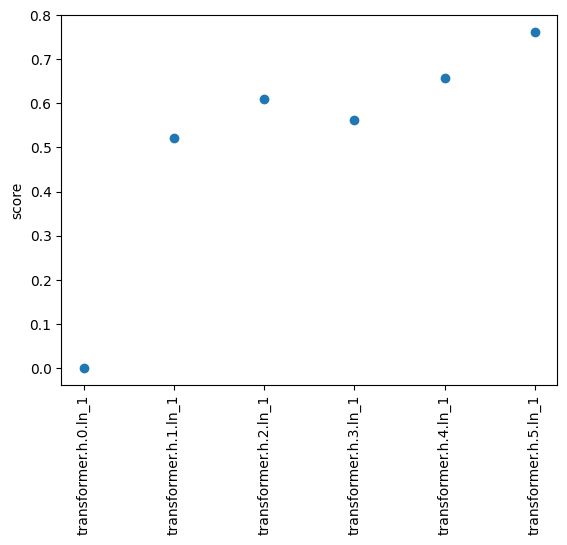

In [9]:
fig, ax = plt.subplots()
x = np.arange(len(layer_scores))
ax.scatter(x, layer_scores)
ax.set_xticks(x)
ax.set_xticklabels(layer_scores['layer'].values, rotation=90)
ax.set_ylabel('score')
fig.show()